# SETUP



In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.optim.lr_scheduler import CosineAnnealingLR # Import the scheduler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [ ]:
class RnnBlock(nn.Module):
    def __init__(self, input_channels, d_model, n_layers=2, dropout=0.1):
        """
        A Bidirectional GRU block for feature extraction.

        Args:
            input_channels (int): Number of channels in the input tensor.
            d_model (int): The target feature dimension for the Transformer.
            n_layers (int): Number of stacked GRU layers.
            dropout (float): Dropout probability for GRU layers.
        """
        super(RnnBlock, self).__init__()
        hidden_size = d_model // 2

        self.gru = nn.GRU(
            input_size=input_channels,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,     # Expects input of shape [batch, seq, feature]
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0 # Dropout is only applied between layers
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor, shape [batch_size, sequence_length, input_channels]
        """
        # The RNN returns:
        # 1. output: The hidden state of the last layer for each time step.
        # 2. h_n: The final hidden state for all layers. We only need the output.
        output, _ = self.gru(x)
        return output

In [ ]:
class MultiScaleConv1d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_sizes=[1, 3, 7]):
        super(MultiScaleConv1d, self).__init__()
        self.convs = nn.ModuleList()

        # Calculate the base number of output channels for each conv layer
        base_channels_per_conv = output_channels // len(kernel_sizes)
        # Calculate any remainder
        remainder_channels = output_channels % len(kernel_sizes)

        current_output_channels = 0
        for i, ks in enumerate(kernel_sizes):
            # Distribute the remainder channels among the first 'remainder_channels' conv layers
            channels_this_conv = base_channels_per_conv + (1 if i < remainder_channels else 0)
            current_output_channels += channels_this_conv

            # Padding to maintain sequence length
            padding = (ks - 1) // 2
            self.convs.append(
                nn.Sequential(
                    nn.Conv1d(input_channels, channels_this_conv, kernel_size=ks, padding=padding),
                    nn.BatchNorm1d(channels_this_conv),
                    nn.ReLU()
                )
            )

    def forward(self, x):
        """
        Args:
            x: Input tensor, shape [batch_size, input_channels, sequence_length]
        """
        outputs = [conv(x) for conv in self.convs]
        # print("printing outputs")
        # for output in outputs:
        #     print(f"Shape after conv: {output.shape}")
        # Concatenate along the channel dimension
        return torch.cat(outputs, dim=1)

In [ ]:
class sequential_conv_block(nn.Module):
  def __init__(self, input_channels, d_model, dropout=0.1,kernel_sizes=[1, 3, 7],seq_len_after_conv=None,seq_length=None):
            super(sequential_conv_block, self).__init__()
            self.seq_length = seq_length
            self.processed_seq_len = seq_len_after_conv if seq_len_after_conv is not None else seq_length

            # Ensure the number of kernel sizes matches the intended number of layers
            if len(kernel_sizes) != 3:
                raise ValueError("sequential_kernel_sizes must be a list of 3 integers.")

            layers = []
            layers.extend([
                nn.Conv1d(input_channels, input_channels*2, kernel_size=kernel_sizes[0], padding=(kernel_sizes[0] - 1) // 2),
                nn.BatchNorm1d(input_channels*2),
                nn.ReLU()
            ])
            layers.extend([
                nn.Conv1d(input_channels*2, input_channels*4, kernel_size=kernel_sizes[1], padding=(kernel_sizes[1] - 1) // 2),
                nn.BatchNorm1d(input_channels*4),
                nn.ReLU()
            ])
            layers.extend([
                nn.Conv1d(input_channels*4, input_channels*4, kernel_size=kernel_sizes[2], padding=(kernel_sizes[2] - 1) // 2),
                nn.BatchNorm1d(input_channels*4),
                nn.ReLU()
            ])

            self.conv_block = nn.Sequential(*layers)
            self.ffn = nn.Linear(input_channels*4,d_model)

  def forward(self, x):
      """
      Args:
          x: Input tensor, shape [batch_size, input_channels, sequence_length]
      """
      x = self.conv_block(x)
      x = x.permute(0, 2, 1)
      x = self.ffn(x)
      #permute back to the original
      x = x.permute(0, 2, 1)
      return x

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_channels, seq_length, num_classes, d_model=128, nhead=4,
                 num_encoder_layers=3, # Increased from 2
                 dim_feedforward_transformer=512, # Increased from 256 (now 4*d_model)
                 conv_kernel_size=3, dropout=0.1,
                 seq_len_after_conv=None, TYPE="sequential"):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.TYPE = TYPE
        self.input_channels = input_channels # Store input_channels


        if self.TYPE == "paralel":

            self.conv_block = MultiScaleConv1d(input_channels, d_model)
            self.processed_seq_len = seq_len_after_conv if seq_len_after_conv is not None else seq_length
        elif self.TYPE == "sequential":

            self.processed_seq_len = seq_len_after_conv if seq_len_after_conv is not None else seq_length
            self.conv_block = sequential_conv_block(input_channels,d_model,dropout)
            # )
        elif self.TYPE == 'linear':

            self.processed_seq_len = seq_length
            self.input_projection = nn.Linear(input_channels, d_model)

        elif self.TYPE == "GRU":

            self.processed_seq_len = seq_length
            self.input_projection = RnnBlock(input_channels, d_model, n_layers=2, dropout=dropout)

        # 2. CLS Token and Learnable Positional Embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        # Positional embedding for CLS token + sequence
        self.pos_embed = nn.Parameter(torch.zeros(1, self.processed_seq_len + 1, d_model))
        self.pos_dropout = nn.Dropout(p=dropout)

        # Could be replaced with Javier initialization.
        nn.init.trunc_normal_(self.cls_token, std=.02)
        nn.init.trunc_normal_(self.pos_embed, std=.02)

        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward_transformer,
            dropout=dropout,
            batch_first=True  # Crucial for (batch, seq, feature) input
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
        )

        # 4. Classification Head
        self.output_dropout = nn.Dropout(p=dropout) # Added dropout before final FFN
        self.final_ffn = nn.Linear(d_model, num_classes)

    def forward(self, src):
        """
        Args:
            src: Input tensor, shape [batch_size, input_channels, sequence_length]
        """
        batch_size = src.shape[0]

        # 1. Optional Convolutional Layers
        if self.TYPE == "paralel" or self.TYPE == "sequential":
            # print("input shape", src.shape)
            conv_out = self.conv_block(src)
            # Permute for Transformer: (batch_size, processed_seq_len, d_model)
            x = conv_out.permute(0, 2, 1)
        else:
            # Permute to (batch_size, sequence_length, input_channels)
            x = src.permute(0, 2, 1)
            # Project to (batch_size, sequence_length, d_model)
            x = self.input_projection(x)

        # print(f"Shape after conv/projection: {x.shape}") # Should be [B, S, D]

        # 2. Prepend CLS token and Add Positional Embedding
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # print(f"Shape after CLS concat: {x.shape}")
        # print(f"Positional embedding shape: {self.pos_embed.shape}")

        # Ensure pos_embed can be broadcasted or sliced correctly
        x = x + self.pos_embed[:, :(x.size(1)), :]
        x = self.pos_dropout(x)

        # print(f"Shape after pos_embed: {x.shape}")

        # 3. Transformer Encoder
        transformer_out = self.transformer_encoder(x)
        # print(f"Shape after transformer: {transformer_out.shape}")

        # 4. Aggregate using CLS token output
        aggregated_out = transformer_out[:, 0] # Take the output of the CLS token

        # 5. Final Classification Head
        aggregated_out = self.output_dropout(aggregated_out)
        output = self.final_ffn(aggregated_out) # Output: (batch_size, num_classes)
        # print(f"Final output shape: {output.shape}")

        return output

In [ ]:
def evaluate_with_dataloader(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())


    accuracy = 100 * correct / total
    # Calculate F1 score
    f1 = f1_score(all_labels, all_predicted, average='weighted') # Use weighted average for multi-class

    return accuracy, f1, all_labels, all_predicted

In [ ]:

def train_with_dataloader(model, train_dataloader, val_dataloader,scheduler,
                          criterion, optimizer, num_epochs,device,promote_sparcity=False,l1_lambda = 0.001,training_threshold=4e-4,patience = 5):
    model.to(device)  # Move the model to the specified device (CPU or GPU)

    train_losses = []  # To store loss per epoch
    val_accuracies = [] # To store validation accuracy per epoch
    best_val_accuracy = -1
    best_result = {
        "val_acc": -1,
        "f1": -1,
        "pred_labels": [],
        "true_labels": []
    }
    for epoch in range(num_epochs):
        total_loss = 0
        model.train()  # Set the model to training mode
        # Iterate over the training data using the DataLoader
        for batch_features, batch_labels in train_dataloader:
            # check if there are any invalid datapoints
            if (torch.isnan(batch_features).any()):
                print("nan values in batch")
                break;
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            out = model(batch_features) # Forward pass
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss = criterion(out, batch_labels) # Calculate loss
            if promote_sparcity:
              l1_penalty = l1_lambda * torch.norm(model.feature_valve.weights, 1)
              loss = loss + l1_penalty
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights


            total_loss += loss.item()
        #update the scheduler
        scheduler.step()
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluate on the validation set
        val_acc,f1,predicted,true_labels = evaluate_with_dataloader(model, val_dataloader, device)
        val_accuracies.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_acc:.2f}%,F1 Score, {100*f1:.2f} LR: {current_lr:.6f}')

        if val_acc > best_val_accuracy:
          best_result = {
            "val_acc": val_acc,
            "f1": f1,
            "pred_labels": predicted,
            "true_labels": true_labels
          }
          best_val_accuracy = val_acc
          epochs_without_improvement = 0 # Reset counter
          # Optionally save the best model state here
          # torch.save(model.state_dict(), 'best_model.pth')
        else:
          epochs_without_improvement += 1 # Increment counter

        if epochs_without_improvement >= patience:
            print(f"Early stopping due to no improvement in validation accuracy for {patience} epochs.")
            break

        if avg_train_loss <= training_threshold:
            print("breaking due to loss below threshold")
            break
    return train_losses, val_accuracies, best_result




# Data processing

In [ ]:
def normalize(data):
  N,M,L = data.shape
  data_norm = np.zeros_like(data)
  for i in range(N):
      for j in range(M):
        if (np.std(data[i,j,:]) >= 10e-10):
          data_norm[i,j,:] = (data[i,j,:] - np.mean(data[i,j,:])) / np.std(data[i,j,:])
        else:
          # if a feature is structure, i.e. static, just copy it over.
          data_norm[i,j,:] = data[i,j,:]
  return data_norm

def names2labels(names):
  y = []
  for file_name in names:
      # Get the first character and convert it to an integer
      integer = int(file_name[0])-1
      y.append(integer)
  return y

def process_data(df, num_features,sequence_length,feature_mask):

  data = np.array(df)
  num_samples = data.shape[0]
  np.random.shuffle(data)
  names_vec = data[:,1]
  x = data[:,2:]
  nan_indices = np.isnan(x.astype(np.float32).any())
  if (nan_indices):
    print("Indices with NaN values:",nan_indices)
    return None,None

  y = names2labels(names_vec)
  x = x.reshape((num_samples,-1,sequence_length))
  x = np.delete(x,feature_mask,axis=1)
  x = normalize(x)
  return x,y

In [ ]:
from torch.utils.data import Dataset, DataLoader
#initialise a dataset class
class CustomRadarDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<H1>Load data</H1>

In [ ]:
df_train = pd.read_csv("n20_denoised_train_no_aug_SVD_peaks.csv")
df_val = pd.read_csv("n20_denoised_val_no_aug_SVD_peaks.csv")
df = pd.concat([df_train,df_val])
#get headers
headers = list(df.columns)
print(headers)

['SampleIndex', 'FileName', 'mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5', 'mean_6', 'mean_7', 'mean_8', 'mean_9', 'mean_10', 'mean_11', 'mean_12', 'mean_13', 'mean_14', 'mean_15', 'mean_16', 'mean_17', 'mean_18', 'mean_19', 'mean_20', 'variance_1', 'variance_2', 'variance_3', 'variance_4', 'variance_5', 'variance_6', 'variance_7', 'variance_8', 'variance_9', 'variance_10', 'variance_11', 'variance_12', 'variance_13', 'variance_14', 'variance_15', 'variance_16', 'variance_17', 'variance_18', 'variance_19', 'variance_20', 'skewness_1', 'skewness_2', 'skewness_3', 'skewness_4', 'skewness_5', 'skewness_6', 'skewness_7', 'skewness_8', 'skewness_9', 'skewness_10', 'skewness_11', 'skewness_12', 'skewness_13', 'skewness_14', 'skewness_15', 'skewness_16', 'skewness_17', 'skewness_18', 'skewness_19', 'skewness_20', 'kurtosis_1', 'kurtosis_2', 'kurtosis_3', 'kurtosis_4', 'kurtosis_5', 'kurtosis_6', 'kurtosis_7', 'kurtosis_8', 'kurtosis_9', 'kurtosis_10', 'kurtosis_11', 'kurtosis_12', 'kurtosi

In [ ]:
# read csv. The output should be (N_samples, total_features)
# Change these per data file.
input_channels = 22  # amount of features per time chunk
sequence_length = 20 # Amount of chunks the time series is split into
num_classes = 6 #  number of output classes


#feature mask deletes features.
feature_mask = np.zeros((input_channels),dtype=bool)
feature_mask[12:22] = False
input_channels = np.nonzero(feature_mask)[0].shape[0]

x_dat,y_dat = process_data(df,input_channels,sequence_length,feature_mask)

print(x_dat.shape)
num_features = x_dat.shape[1]
input_channels = num_features

(1754, 22, 20)


# K-fold cross validation

In [ ]:
batch_size = 128
d_model =  256  # Embedding dimension (must be divisible by nhead)
nhead = 8   # Number of heads in multi-head attention
num_encoder_layers = 4 # Number of encoder layers in transformer
dim_feedforward_transformer = 4*d_model # Dim of FFN in TransformerEncoderLayer
conv_kernel_size = 3 # deprecated, all convolution is [1,3,7]
dropout = 0.1
num_epochs = 50
learning_rate = 0.0005
gamma = 0.98

patience = 20

l1_lambda = 0.5
TYPE = "paralel"

folds = 7

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Assuming CustomRadarDataset, TransformerModel, evaluate_with_dataloader, train_with_dataloader are defined above

k = folds
num_samples = x_dat.shape[0]
#split x,y into k chunks
x_split = np.array_split(x_dat, k, axis=0)
y_split = np.array_split(y_dat, k, axis=0)


performance_data = []

for i in range(k):
  print(f"\n--- Starting Fold {i+1}/{k} ---")
  # select training and validation sets
  # The i-th fold is the validation set
  val_set = x_split[i]
  val_labels = y_split[i]

  # The remaining folds are the training set
  train_set_list = [x_split[j] for j in range(k) if j != i]
  train_labels_list = [y_split[j] for j in range(k) if j != i]

  train_set = np.concatenate(train_set_list)
  train_labels = np.concatenate(train_labels_list)

  print(f"train set shape {train_set.shape}")
  print(f"train labels shape {train_labels.shape}")
  print(f"validation set shape {val_set.shape}")
  print(f"validation labels shape {val_labels.shape}")


  x = torch.tensor(train_set.astype(np.float32), dtype=torch.float32)
  y = torch.tensor(train_labels, dtype=torch.long)
  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device is already defined globally

  x_val = torch.tensor(val_set.astype(np.float32), dtype=torch.float32)
  y_val = torch.tensor(val_labels, dtype=torch.long)

  train_dataset = CustomRadarDataset(x, y)
  val_dataset = CustomRadarDataset(x_val, y_val)

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  model = TransformerModel(
        input_channels=input_channels,
        seq_length = sequence_length,
        num_classes=num_classes,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward_transformer=dim_feedforward_transformer,
        conv_kernel_size=conv_kernel_size,
        dropout=dropout,
        seq_len_after_conv=sequence_length, # Ensure this is correct after your conv block
        TYPE = TYPE
  )


  optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
  #for Decaying learning rate we use a scheduler.
  # scheduler = ExponentialLR(optimizer, gamma=gamma)
  scheduler = CosineAnnealingLR(optimizer,num_epochs,eta_min = learning_rate/20)
  criterion = nn.CrossEntropyLoss()
  print(f"K_fold {i+1}") # Print current fold number

  losses, accuracy,best_result = train_with_dataloader(model, train_dataloader, val_dataloader, scheduler,
                                         criterion, optimizer, num_epochs,device,
                                         promote_sparcity = False, l1_lambda = l1_lambda,
                                         training_threshold=1e-3,
                                          patience = patience)

  # print(f"best epoch: accuracy {best_result["val_acc"]:.2f}% f1 {best_result["f1"]:.2f}")

  entry = {
      "fold": i + 1, # Add fold number
      "losses": losses,
      "accuracy": accuracy,
      "val_accuracy": best_result["val_acc"],
      "f1_score": best_result["f1"],
      "true_labels": best_result["true_labels"],
      "predicted_labels": best_result["pred_labels"]
  }
  performance_data.append(entry)



--- Starting Fold 1/7 ---
train set shape (1503, 22, 20)
train labels shape (1503,)
validation set shape (251, 22, 20)
validation labels shape (251,)
K_fold 1
Epoch 1/50, Train Loss: 1.3814, Validation Accuracy: 62.15%,F1 Score, 59.94 LR: 0.000500
Epoch 2/50, Train Loss: 0.8057, Validation Accuracy: 72.11%,F1 Score, 72.13 LR: 0.000498
Epoch 3/50, Train Loss: 0.5633, Validation Accuracy: 76.10%,F1 Score, 74.19 LR: 0.000496
Epoch 4/50, Train Loss: 0.4515, Validation Accuracy: 79.28%,F1 Score, 79.15 LR: 0.000493
Epoch 5/50, Train Loss: 0.4159, Validation Accuracy: 82.07%,F1 Score, 81.07 LR: 0.000488
Epoch 6/50, Train Loss: 0.3533, Validation Accuracy: 82.07%,F1 Score, 81.79 LR: 0.000483
Epoch 7/50, Train Loss: 0.2844, Validation Accuracy: 82.07%,F1 Score, 80.88 LR: 0.000477
Epoch 8/50, Train Loss: 0.2753, Validation Accuracy: 82.47%,F1 Score, 81.93 LR: 0.000471
Epoch 9/50, Train Loss: 0.2206, Validation Accuracy: 88.45%,F1 Score, 88.58 LR: 0.000463
Epoch 10/50, Train Loss: 0.1810, Valida

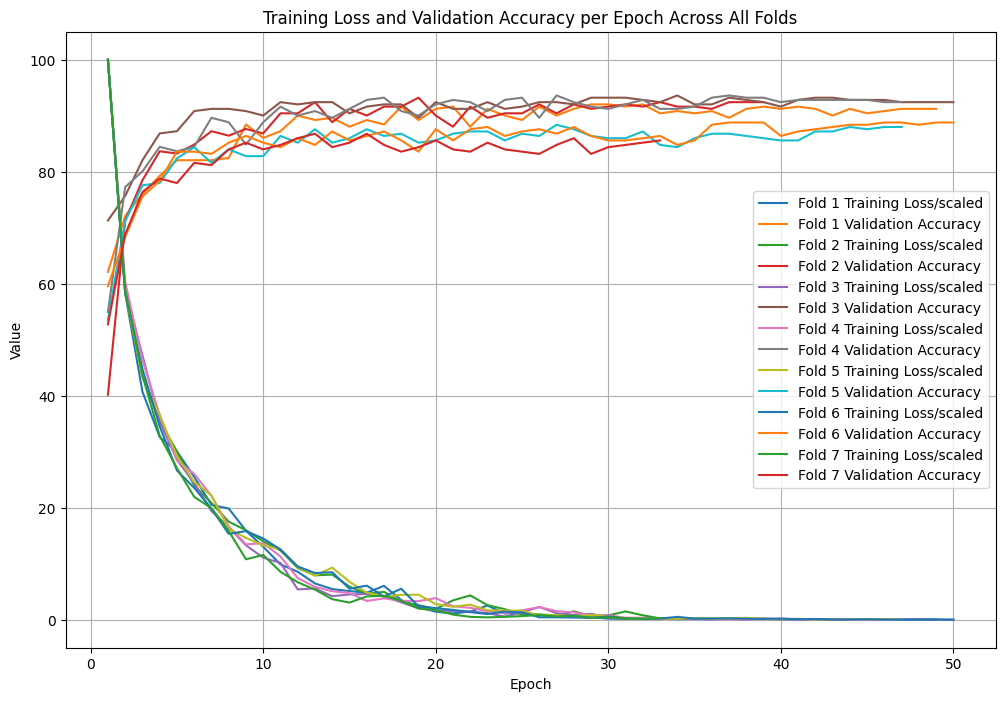

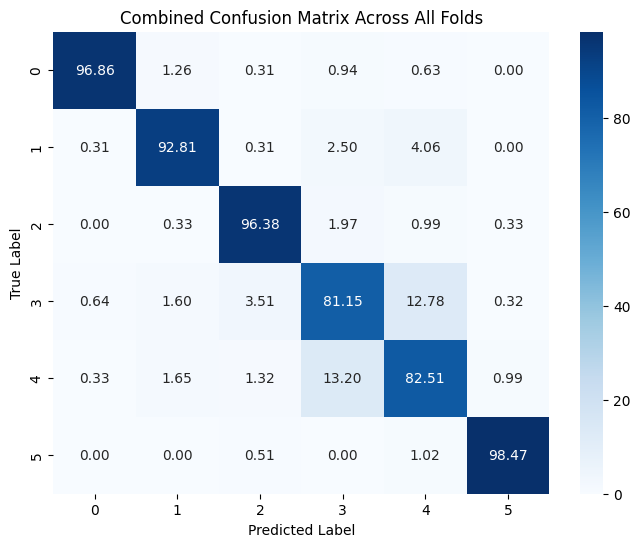

Overall Validation Accuracy Across All Folds: 90.93%


In [ ]:
# Combine results from all folds

all_true_labels = []
all_predicted_labels = []

plt.figure(figsize=(12, 8))
for i, fold_data in enumerate(performance_data):
    # Plot training loss and validation accuracy for each fold
    epochs = len(fold_data['losses'])
    plt.plot(range(1, epochs + 1), [l * 100/max(fold_data['losses']) for l in fold_data['losses']], label=f'Fold {fold_data["fold"]} Training Loss/scaled')
    plt.plot(range(1, epochs + 1), fold_data['accuracy'], label=f'Fold {fold_data["fold"]} Validation Accuracy')

    # Collect labels for combined confusion matrix
    all_true_labels.extend(fold_data['true_labels'])
    all_predicted_labels.extend(fold_data['predicted_labels'])

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Accuracy per Epoch Across All Folds')
plt.legend()
plt.grid(True)
plt.show()

# Compute the combined confusion matrix
combined_cm = confusion_matrix(all_true_labels, all_predicted_labels, normalize='true')

# Convert the combined confusion matrix to percentages
combined_cm_percentage = combined_cm * 100

# Display the combined confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(combined_cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Combined Confusion Matrix Across All Folds')
plt.show()

# Calculate and print overall accuracy
overall_accuracy = (sum([max(fold_data["accuracy"]) for fold_data in performance_data]) / k)
overall_f1_score = (sum([fold_data["f1_score"] for fold_data in performance_data]) / k)
print(f"Overall Validation Accuracy Across All Folds: {overall_accuracy:.2f}%")
# print(f"Overall f1 score over all folds: {}")


# Training and validation on representative data

In [ ]:
batch_size = 128
d_model =  256  # Embedding dimension (must be divisible by nhead)
nhead = 8   # Number of heads in multi-head attention
num_encoder_layers = 4 # Number of encoder layers in transformer
dim_feedforward_transformer = 4*d_model # Dim of FFN in TransformerEncoderLayer
conv_kernel_size = 3 # deprecated, all convolution is [1,3,7]
dropout = 0.1
num_epochs = 50
learning_rate = 0.0005
gamma = 0.98

patience = 20

l1_lambda = 0.5
TYPE = "paralel"

x_dat,y_dat = process_data(df_train,input_channels,sequence_length,feature_mask)
x_dat_val,y_dat_val  = process_data(df_val,input_channels,sequence_length,feature_mask)

x = torch.tensor(x_dat.astype(np.float32), dtype=torch.float32)
y = torch.tensor(y_dat, dtype=torch.long)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device is already defined globally

x_val = torch.tensor(x_dat_val.astype(np.float32), dtype=torch.float32)
y_val = torch.tensor(y_dat_val, dtype=torch.long)

train_dataset = CustomRadarDataset(x, y)
val_dataset = CustomRadarDataset(x_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = TransformerModel(
        input_channels=input_channels,
        seq_length = sequence_length,
        num_classes=num_classes,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward_transformer=dim_feedforward_transformer,
        conv_kernel_size=conv_kernel_size,
        dropout=dropout,
        seq_len_after_conv=sequence_length, # Ensure this is correct after your conv block
        TYPE = TYPE
  )


optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer,num_epochs,eta_min = learning_rate/20)
criterion = nn.CrossEntropyLoss()

losses, accuracy,best_result = train_with_dataloader(model, train_dataloader, val_dataloader, scheduler,
                                        criterion, optimizer, num_epochs,device,
                                        promote_sparcity = False, l1_lambda = l1_lambda,
                                        training_threshold=1e-3,
                                        patience = patience)

# save model weights
torch.save(model.state_dict(), 'model_weights.pth')

Epoch 1/50, Train Loss: 1.4516, Validation Accuracy: 52.84%,F1 Score, 52.77 LR: 0.000500
Epoch 2/50, Train Loss: 0.8262, Validation Accuracy: 72.44%,F1 Score, 71.40 LR: 0.000498
Epoch 3/50, Train Loss: 0.6167, Validation Accuracy: 77.84%,F1 Score, 76.82 LR: 0.000496
Epoch 4/50, Train Loss: 0.4958, Validation Accuracy: 76.42%,F1 Score, 74.57 LR: 0.000493
Epoch 5/50, Train Loss: 0.4021, Validation Accuracy: 82.39%,F1 Score, 82.16 LR: 0.000488
Epoch 6/50, Train Loss: 0.3644, Validation Accuracy: 82.39%,F1 Score, 81.78 LR: 0.000483
Epoch 7/50, Train Loss: 0.2857, Validation Accuracy: 84.38%,F1 Score, 84.27 LR: 0.000477
Epoch 8/50, Train Loss: 0.2380, Validation Accuracy: 86.36%,F1 Score, 86.61 LR: 0.000471
Epoch 9/50, Train Loss: 0.2011, Validation Accuracy: 87.78%,F1 Score, 87.86 LR: 0.000463
Epoch 10/50, Train Loss: 0.1816, Validation Accuracy: 86.36%,F1 Score, 86.50 LR: 0.000455
Epoch 11/50, Train Loss: 0.1635, Validation Accuracy: 86.08%,F1 Score, 86.19 LR: 0.000445
Epoch 12/50, Train 

# Loading a trained model

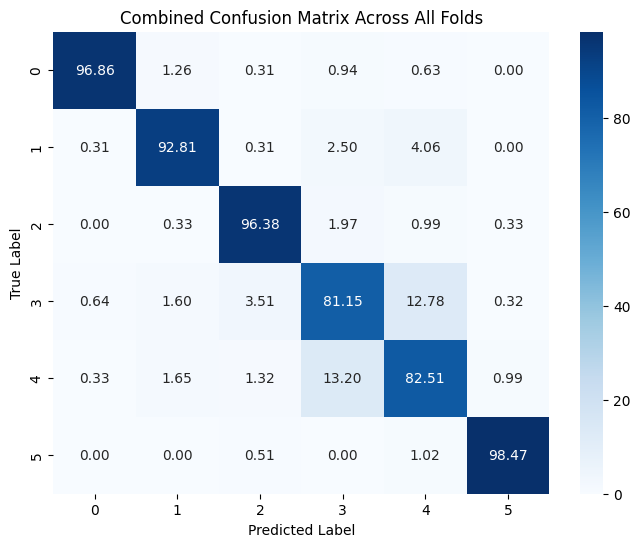

F1 score: 89.84%


In [ ]:

batch_size = 128
d_model =  256  # Embedding dimension (must be divisible by nhead)
nhead = 8   # Number of heads in multi-head attention
num_encoder_layers = 4 # Number of encoder layers in transformer
dim_feedforward_transformer = 4*d_model # Dim of FFN in TransformerEncoderLayer
conv_kernel_size = 3 # deprecated, all convolution is [1,3,7]
dropout = 0.1
num_epochs = 50
learning_rate = 0.0005
gamma = 0.98

patience = 20

l1_lambda = 0.5
TYPE = "paralel"
model = TransformerModel(
    input_channels=input_channels,
    seq_length = sequence_length,
    num_classes=num_classes,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward_transformer=dim_feedforward_transformer,
    conv_kernel_size=conv_kernel_size,
    dropout=dropout,
    seq_len_after_conv=sequence_length,
    TYPE = TYPE
)

# 2. Load the state dictionary
model.load_state_dict(torch.load('model_weights.pth'))

# 3. Move the model to the desired device (CPU or GPU)
model.to(device)

# 4. load data
x_dat_val,y_dat_val  = process_data(df_val,input_channels,sequence_length,feature_mask)

x_val = torch.tensor(x_dat_val.astype(np.float32), dtype=torch.float32)
y_val = torch.tensor(y_dat_val, dtype=torch.long)

val_dataset = CustomRadarDataset(x_val, y_val)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# 5. perform validation

model.eval()  # Set the model to evaluation mode
accuracy, f1, all_labels, all_predicted = evaluate_with_dataloader(model,val_dataloader,device)

# 6. visualize results
# Compute the combined confusion matrix
Confusion_matrix = confusion_matrix(all_true_labels, all_predicted_labels, normalize='true')

# Convert the combined confusion matrix to percentages
Confusion_matrix_perc = combined_cm * 100

# Display the combined confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_matrix_perc, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Combined Confusion Matrix Across All Folds')
plt.show()

print(f"F1 score: {f1*100:.2f}%")

In [ ]:
# GRID SEARCH
import itertools
# Define the parameter grid
param_grid = {
    'd_model': [64,128, 256],
    'nhead': [4,8],
    'num_encoder_layers': [4, 6,8],
    'dropout': [0,0.1],
    "TYPE": ["sequential","paralel","GRU","linear"]
}
df_train = pd.read_csv("n20_denoised_train_no_aug_SVD_peaks.csv")
df_val = pd.read_csv("n20_denoised_val_no_aug_SVD_peaks.csv")

input_channels = 22  # amount of features per time chunk
sequence_length = 20 # Amount of chunks the time series is split into
num_classes = 6 #  number of output classes


#feature mask deletes features.
feature_mask = np.zeros((input_channels),dtype=bool)
feature_mask[12:21] = False
input_channels = np.nonzero(feature_mask)[0].shape[0]

x_dat,y_dat = process_data(df_train,input_channels,sequence_length,feature_mask)
x_dat_val,y_dat_val  = process_data(df_val,input_channels,sequence_length,feature_mask)

x = torch.tensor(x_dat.astype(np.float32), dtype=torch.float32)
y = torch.tensor(y_dat, dtype=torch.long)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device is already defined globally

x_val = torch.tensor(x_dat_val.astype(np.float32), dtype=torch.float32)
y_val = torch.tensor(y_dat_val, dtype=torch.long)

train_dataset = CustomRadarDataset(x, y)
val_dataset = CustomRadarDataset(x_val, y_val)

print(x_dat.shape)
num_features = x_dat.shape[1]
input_channels = num_features
best_accuracy = 0
best_params = {}
results = []
batch_size = 256
# Get all combinations of parameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total combinations to test: {len(param_combinations)}")

# Assuming your dataset and device are already defined from the previous cells
# train_dataset, val_dataset, device, input_channels, num_classes, sequence_length

for i, params in enumerate(param_combinations):
    print(f"\n--- Testing combination {i+1}/{len(param_combinations)} ---")
    print(f"Parameters: {params}")

    # Update batch size for dataloaders
    batch_size = batch_size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model with current parameters
    model = TransformerModel(
          input_channels=input_channels,
          seq_length = sequence_length,
          num_classes=num_classes,
          d_model=params['d_model'],
          nhead=params['nhead'],
          num_encoder_layers=params['num_encoder_layers'],
          dim_feedforward_transformer=params['d_model']*4,
          conv_kernel_size=3,
          dropout=params['dropout'],
          TYPE = params["TYPE"],
          seq_len_after_conv=20 # Pass the expected seq len after convs,
    )

    # Define optimizer and scheduler with current parameters
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate the model
    # You can adjust the number of epochs for the grid search if needed
    # to save computation time, e.g., num_epochs = 20
    num_epochs_grid_search = 100
    train_losses, val_accuracies,best_result = train_with_dataloader(
        model, train_dataloader, val_dataloader, scheduler, criterion, optimizer,
          num_epochs_grid_search, device,training_threshold=8e-4,
          patience = 10
    )

    # Get the best validation accuracy from this run
    current_best_accuracy = max(val_accuracies) if val_accuracies else 0

    # Store results
    results.append({
        'params': params,
        'best_val_accuracy': best_result["f1"],
        'val_accuracies_per_epoch': val_accuracies, # Optional: store for analysis
        'train_losses_per_epoch': train_losses # Optional: store for analysis
    })

    # Update best parameters if current accuracy is better
    if current_best_accuracy > best_accuracy:
        best_accuracy = current_best_accuracy
        best_params = params
        print(f"New best accuracy: {best_accuracy:.2f}% with parameters: {best_params}")

print("\n--- Grid Search Complete ---")
print(f"Best validation accuracy found: {best_accuracy:.2f}%")
print(f"Best parameters: {best_params}")


Streaming output truncated to the last 5000 lines.
Epoch 70/100, Train Loss: 0.1278, Validation Accuracy: 85.51%,F1 Score, 85.42 LR: 0.000122
Epoch 71/100, Train Loss: 0.1194, Validation Accuracy: 84.66%,F1 Score, 84.51 LR: 0.000119
Epoch 72/100, Train Loss: 0.1100, Validation Accuracy: 86.36%,F1 Score, 86.35 LR: 0.000117
Early stopping due to no improvement in validation accuracy for 10 epochs.

--- Testing combination 39/144 ---
Parameters: {'d_model': 64, 'nhead': 8, 'num_encoder_layers': 6, 'dropout': 0.1, 'TYPE': 'GRU'}
Epoch 1/100, Train Loss: 1.7798, Validation Accuracy: 36.65%,F1 Score, 29.18 LR: 0.000490
Epoch 2/100, Train Loss: 1.5603, Validation Accuracy: 42.61%,F1 Score, 40.72 LR: 0.000480
Epoch 3/100, Train Loss: 1.3751, Validation Accuracy: 52.27%,F1 Score, 51.69 LR: 0.000471
Epoch 4/100, Train Loss: 1.2734, Validation Accuracy: 55.11%,F1 Score, 54.06 LR: 0.000461
Epoch 5/100, Train Loss: 1.1950, Validation Accuracy: 59.66%,F1 Score, 60.30 LR: 0.000452
Epoch 6/100, Train 

# Hyperparameter grid search

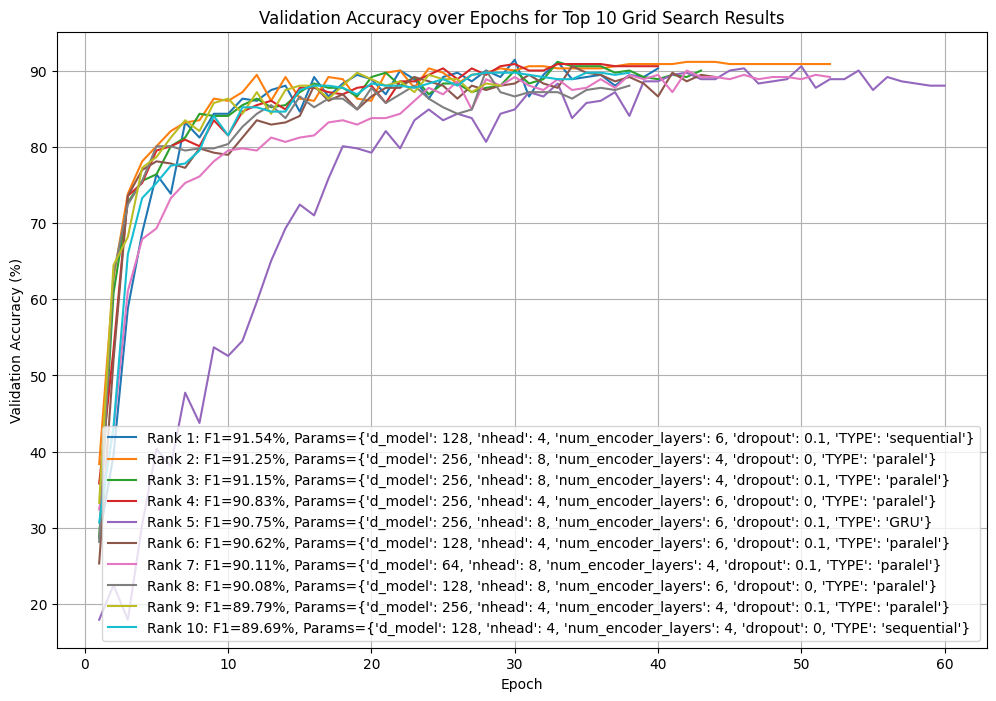

In [ ]:
# Sort the results by best_val_accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['best_val_accuracy'], reverse=True)

# Take the top 10 results
top_10_results = sorted_results[:10]

# Plotting the validation accuracy for the top 10 results
plt.figure(figsize=(12, 8))

for i, result in enumerate(top_10_results):
    params = result['params']
    val_accuracies = result['val_accuracies_per_epoch']
    epochs = len(val_accuracies)
    label = f"Rank {i+1}: F1={100*result['best_val_accuracy']:.2f}%, Params={params}"
    plt.plot(range(1, epochs + 1), val_accuracies, label=label)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy over Epochs for Top 10 Grid Search Results')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: sort results by accuracy, give top 10 results

# Sort the results by best_val_accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['best_val_accuracy'], reverse=True)

# Print the top 10 results
print("\n--- Top 10 Results by Validation Accuracy ---")
for i, result in enumerate(sorted_results[:10]):
  print(f"Rank {i+1}: Accuracy: {result['best_val_accuracy']:.2f}%, Params: {result['params']}")


--- Top 10 Results by Validation Accuracy ---
Rank 1: Accuracy: 0.92%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 6, 'dropout': 0.1, 'TYPE': 'sequential'}
Rank 2: Accuracy: 0.91%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 4, 'dropout': 0, 'TYPE': 'paralel'}
Rank 3: Accuracy: 0.91%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 4, 'dropout': 0.1, 'TYPE': 'paralel'}
Rank 4: Accuracy: 0.91%, Params: {'d_model': 256, 'nhead': 4, 'num_encoder_layers': 6, 'dropout': 0, 'TYPE': 'paralel'}
Rank 5: Accuracy: 0.91%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 6, 'dropout': 0.1, 'TYPE': 'GRU'}
Rank 6: Accuracy: 0.91%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 6, 'dropout': 0.1, 'TYPE': 'paralel'}
Rank 7: Accuracy: 0.90%, Params: {'d_model': 64, 'nhead': 8, 'num_encoder_layers': 4, 'dropout': 0.1, 'TYPE': 'paralel'}
Rank 8: Accuracy: 0.90%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 6, 'dropout': 0, 'TYP

Grid search results:

defaults:

batch size = 128,

num_epochs = 50,

training loss threshold = 5e-3,

learning_rate = 0.0005,

gamma = 0.98,

dropout = 0.1

actual results: take it with a grain of salt:

Rank 1: Accuracy: 92.05%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 5}

Rank 2: Accuracy: 92.05%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 3}

Rank 3: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}

Rank 4: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 3}

Rank 5: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}

Rank 6: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 512, 'conv_kernel_size': 5}

Rank 7: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 512, 'conv_kernel_size': 5}

Rank 8: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}

Rank 9: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 512, 'conv_kernel_size': 3}

Rank 10: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 16, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}


second:
Rank 1: Accuracy: 90.87%, Params: {'d_model': 512, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 256}


Rank 2: Accuracy: 90.49%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 256}


Rank 3: Accuracy: 90.11%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 256}


Rank 4: Accuracy: 90.11%, Params: {'d_model': 256, 'nhead': 16, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 128}


Rank 5: Accuracy: 90.11%, Params: {'d_model': 384, 'nhead': 4, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 128}


Rank 6: Accuracy: 90.11%, Params: {'d_model': 384, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256}


Rank 7: Accuracy: 90.11%, Params: {'d_model': 512, 'nhead': 8, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 256}


Rank 8: Accuracy: 89.73%, Params: {'d_model': 128, 'nhead': 16, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256}


Rank 9: Accuracy: 89.73%, Params: {'d_model': 128, 'nhead': 16, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 256}


Rank 10: Accuracy: 89.73%, Params: {'d_model': 256, 'nhead': 4, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 256}